In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ตั้งค่า matplotlib ตามที่ระบุ
font = {'size': 16}
plt.rc('font', **font)

In [2]:
# ฟังก์ชันตรวจจับ Moonshot
def detect_moonshot(data, window=12, threshold=0.05):
    moonshots = []
    for i in range(len(data) - window):
        if moonshots and (data.index[i] - moonshots[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Moonshot ใหม่เริ่มภายใน 12 ชั่วโมงจากครั้งก่อน
        close_price = data['close'].iloc[i]
        high_price = data['high'].iloc[i:i+window].max()
        low_price = data['low'].iloc[i:i+window].min()
        moonshot_pct = (high_price - close_price) / close_price
        if moonshot_pct >= threshold and (low_price - close_price) / close_price > -0.03:
            high_idx = data['high'].iloc[i:i+window].idxmax()
            moonshots.append({
                'start_time': data.index[i],
                'peak_time': high_idx,
                'close_price': close_price,
                'high_price': high_price,
                'moonshot_pct': moonshot_pct * 100,
                'window_end_time': data.index[i+window-1]
            })
    return pd.DataFrame(moonshots)

In [3]:
# อ่านข้อมูลจากไฟล์ pickle
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))
# ตั้ง index เป็น DatetimeIndex ถ้ายังไม่ได้ตั้ง
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data['time'])
# เลือกคอลัมน์ที่จำเป็น
data = data[['open', 'high', 'low', 'close', 'volume']]

# คำนวณ RSI และ MACD (เพื่อใช้ในกรณีวิเคราะห์เพิ่มเติม)
import pandas_ta as ta
data['rsi'] = ta.rsi(data['close'], length=14)
macd = ta.macd(data['close'], fast=12, slow=26, signal=9)
data['macd'] = macd['MACD_12_26_9']
data['macd_signal'] = macd['MACDs_12_26_9']
data['macd_hist'] = macd['MACDh_12_26_9']

# ตรวจจับ Moonshot
moonshots = detect_moonshot(data, window=12, threshold=0.05)

# หา All Time High (ATH)
data['cum_max_high'] = data['high'].cummax()
data['is_ath'] = (data['high'] == data['cum_max_high']) & (data['high'] > data['cum_max_high'].shift(1))
ath_points = data[data['is_ath']].copy()
ath_points = ath_points[['high', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'volume']]

# ตรวจสอบว่า ATH อยู่ในช่วง Moonshot หรือไม่
ath_points['in_moonshot'] = False
ath_points['moonshot_start_time'] = np.nan
ath_points['moonshot_peak_time'] = np.nan
ath_points['moonshot_pct'] = np.nan

for ath_time in ath_points.index:
    for _, moonshot in moonshots.iterrows():
        if ath_time >= moonshot['start_time'] and ath_time <= moonshot['window_end_time']:
            ath_points.loc[ath_time, 'in_moonshot'] = True
            ath_points.loc[ath_time, 'moonshot_start_time'] = moonshot['start_time']
            ath_points.loc[ath_time, 'moonshot_peak_time'] = moonshot['peak_time']
            ath_points.loc[ath_time, 'moonshot_pct'] = moonshot['moonshot_pct']
            break

/tmp/ipykernel_21887/1123273729.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2017-08-24 12:00:00+00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ath_points.loc[ath_time, 'moonshot_start_time'] = moonshot['start_time']
/tmp/ipykernel_21887/1123273729.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2017-08-24 23:00:00+00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ath_points.loc[ath_time, 'moonshot_peak_time'] = moonshot['peak_time']


In [4]:
# สรุปผล
total_ath = len(ath_points)
ath_in_moonshot = ath_points['in_moonshot'].sum()
percent_in_moonshot = (ath_in_moonshot / total_ath * 100) if total_ath > 0 else 0

print(f"Summary of ATH and Moonshot Analysis (5% in 12 Hours):")
print(f"Total ATH Points: {total_ath}")
print(f"ATH Points in Moonshot: {ath_in_moonshot}")
print(f"Percentage of ATH in Moonshot: {percent_in_moonshot:.2f}%")

Summary of ATH and Moonshot Analysis (5% in 12 Hours):
Total ATH Points: 379
ATH Points in Moonshot: 178
Percentage of ATH in Moonshot: 46.97%


In [5]:
# สรุปสถิติของ Moonshot ที่มี ATH
if ath_in_moonshot > 0:
    ath_moonshots = ath_points[ath_points['in_moonshot']]
    print("\nStatistics of Moonshots Containing ATH:")
    stats = {
        'Count': len(ath_moonshots),
        'Mean Moonshot Size (%)': ath_moonshots['moonshot_pct'].mean(),
        'Std Moonshot Size (%)': ath_moonshots['moonshot_pct'].std(),
        'Min Moonshot Size (%)': ath_moonshots['moonshot_pct'].min(),
        'Max Moonshot Size (%)': ath_moonshots['moonshot_pct'].max(),
        'Median Moonshot Size (%)': ath_moonshots['moonshot_pct'].median(),
        'Mean RSI at ATH': ath_moonshots['rsi'].mean(),
        'Mean Volume at ATH': ath_moonshots['volume'].mean()
    }
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")


Statistics of Moonshots Containing ATH:
Count: 178.00
Mean Moonshot Size (%): 7.31
Std Moonshot Size (%): 2.80
Min Moonshot Size (%): 5.00
Max Moonshot Size (%): 13.45
Median Moonshot Size (%): 5.84
Mean RSI at ATH: 74.70
Mean Volume at ATH: 3920.78


In [6]:
# สร้างตาราง ATH
ath_summary = ath_points[['high', 'in_moonshot', 'moonshot_start_time', 'moonshot_peak_time', 'moonshot_pct', 'rsi', 'volume']].reset_index()
ath_summary.columns = ['ATH Time', 'ATH Price', 'In Moonshot', 'Moonshot Start Time', 'Moonshot Peak Time', 'Moonshot Size (%)', 'RSI at ATH', 'Volume at ATH']
print("\nATH Summary Table:")
print(ath_summary.round(2).to_string(index=False))


ATH Summary Table:
                 ATH Time  ATH Price  In Moonshot       Moonshot Start Time        Moonshot Peak Time  Moonshot Size (%)  RSI at ATH  Volume at ATH
2017-08-18 08:00:00+00:00    4320.71        False                       NaN                       NaN                NaN         NaN          74.83
2017-08-18 09:00:00+00:00    4327.25        False                       NaN                       NaN                NaN         NaN          45.65
2017-08-18 10:00:00+00:00    4371.52        False                       NaN                       NaN                NaN         NaN          51.56
2017-08-24 23:00:00+00:00    4371.68         True 2017-08-24 12:00:00+00:00 2017-08-24 23:00:00+00:00               5.32       67.35          35.78
2017-08-25 15:00:00+00:00    4422.29        False                       NaN                       NaN                NaN       63.50          21.80
2017-08-25 16:00:00+00:00    4453.91        False                       NaN                 

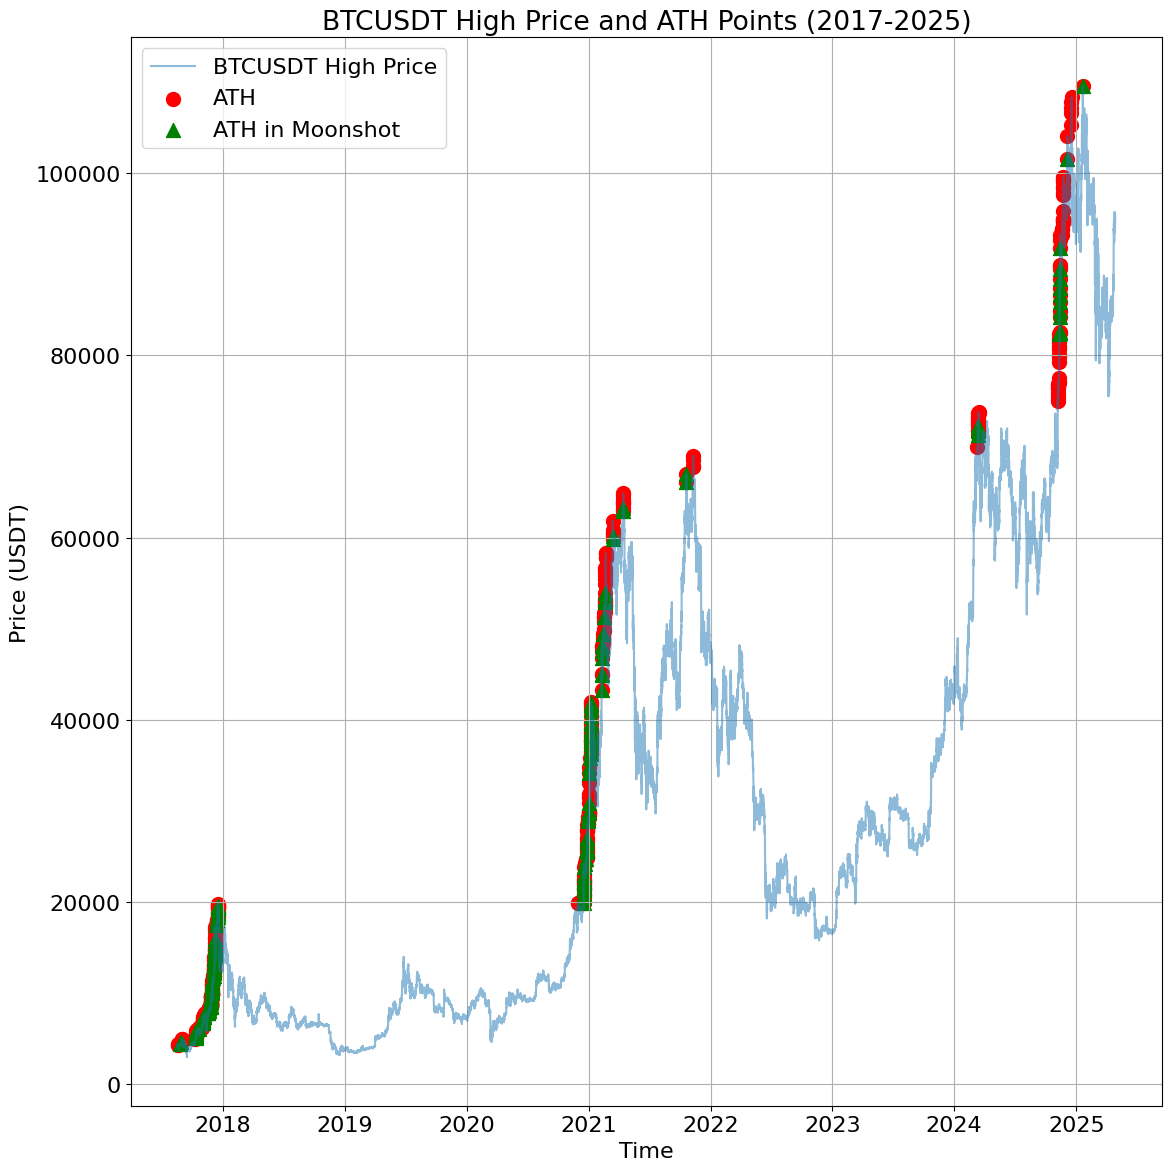

In [7]:
# กราห์แสดง ATH และ Moonshot
plt.figure(figsize=(12, 12))
plt.plot(data.index, data['high'], label='BTCUSDT High Price', alpha=0.5)
plt.scatter(ath_points.index, ath_points['high'], color='red', label='ATH', s=100)
plt.scatter(ath_points[ath_points['in_moonshot']].index, ath_points[ath_points['in_moonshot']]['high'], color='green', label='ATH in Moonshot', s=100, marker='^')
plt.title('BTCUSDT High Price and ATH Points (2017-2025)')
plt.xlabel('Time')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()